In [1]:
import numpy as np 
import matplotlib.pyplot as plt
seq_dim=(12,12)

magn = np.arange(-np.prod(seq_dim), np.prod(seq_dim)+1, 2)
bins=np.linspace(magn[0]-1, magn[-1]+1, np.prod(seq_dim)+1+1)

In [2]:
import os
import glob
def loadmodelprediction(_dirname, epoch=None, num_batches=1):
    dirname = _dirname
    f_logits_t = sorted(glob.glob(os.path.join(dirname, "logits_val_inttime*")))
    print(">>> Reading model predictions from: ", dirname)

    logits_t = [np.load(f).astype(np.float16) for f in f_logits_t]
    diffusion_t = [float(x.replace(os.path.join(dirname, "logits_val_inttime"), "").replace(".npy",""))-1 for x in f_logits_t]

    for ii in range(num_batches):
        if ii == 0:
            print("        ", len(logits_t), [logits_t[i].shape for i in range(len(logits_t))])
            continue
        dirname = _dirname+"../epoch%d_sampleIntStep80_%d"%(epoch,ii+1)
        _f_logits_t = sorted(glob.glob(os.path.join(dirname, "logits_val_inttime*")))
        _logits_t = [np.load(f).astype(np.float16) for f in _f_logits_t]
        print("        ", ii+1,len(_logits_t), [_logits_t[i].shape for i in range(len(_f_logits_t))])
        logits_t = [np.concatenate([logits_t[i], _logits_t[i]], axis=0) for i in range(len(_f_logits_t))]
    return logits_t, diffusion_t

def logits2seq(logits_t):
    seq_t = []
    for logits in logits_t:
        seq = np.argmax(logits, axis=-1)
        seq[np.where(seq==0)] = -1
        seq_t.append(seq.reshape(-1,*seq_dim))
    return seq_t

def Ising_magnetization(seq):
    data = np.sum(seq.reshape([-1,np.prod(seq_dim)]), axis=-1)
    return data

def histvar(seq, varfunc, bins):
    var = varfunc(seq)
    hist, bin_edges = np.histogram(var, bins=bins)
    bin_centers = np.array([(bin_edges[i]+bin_edges[i+1])/2. for i in range(len(bin_edges)-1)])
    P = hist/np.sum(hist)
    idxF = np.where(hist>0)
    F = -np.log(P[idxF])
    return hist, bin_centers, P, F, idxF

In [3]:
logits_t, diffusion_t = loadmodelprediction("./")


>>> Reading model predictions from:  ./
         40 [(1024, 12, 12, 2), (1024, 12, 12, 2), (1024, 12, 12, 2), (1024, 12, 12, 2), (1024, 12, 12, 2), (1024, 12, 12, 2), (1024, 12, 12, 2), (1024, 12, 12, 2), (1024, 12, 12, 2), (1024, 12, 12, 2), (1024, 12, 12, 2), (1024, 12, 12, 2), (1024, 12, 12, 2), (1024, 12, 12, 2), (1024, 12, 12, 2), (1024, 12, 12, 2), (1024, 12, 12, 2), (1024, 12, 12, 2), (1024, 12, 12, 2), (1024, 12, 12, 2), (1024, 12, 12, 2), (1024, 12, 12, 2), (1024, 12, 12, 2), (1024, 12, 12, 2), (1024, 12, 12, 2), (1024, 12, 12, 2), (1024, 12, 12, 2), (1024, 12, 12, 2), (1024, 12, 12, 2), (1024, 12, 12, 2), (1024, 12, 12, 2), (1024, 12, 12, 2), (1024, 12, 12, 2), (1024, 12, 12, 2), (1024, 12, 12, 2), (1024, 12, 12, 2), (1024, 12, 12, 2), (1024, 12, 12, 2), (1024, 12, 12, 2), (1024, 12, 12, 2)]


In [18]:
print([logits.shape for logits in logits_t])
print(max(diffusion_t))

[(1024, 6, 6, 2), (1024, 6, 6, 2), (1024, 6, 6, 2), (1024, 6, 6, 2), (1024, 6, 6, 2), (1024, 6, 6, 2), (1024, 6, 6, 2), (1024, 6, 6, 2), (1024, 6, 6, 2), (1024, 6, 6, 2), (1024, 6, 6, 2), (1024, 6, 6, 2), (1024, 6, 6, 2), (1024, 6, 6, 2), (1024, 6, 6, 2), (1024, 6, 6, 2), (1024, 6, 6, 2), (1024, 6, 6, 2), (1024, 6, 6, 2), (1024, 6, 6, 2), (1024, 6, 6, 2), (1024, 6, 6, 2), (1024, 6, 6, 2), (1024, 6, 6, 2), (1024, 6, 6, 2), (1024, 6, 6, 2), (1024, 6, 6, 2), (1024, 6, 6, 2), (1024, 6, 6, 2), (1024, 6, 6, 2), (1024, 6, 6, 2), (1024, 6, 6, 2), (1024, 6, 6, 2), (1024, 6, 6, 2), (1024, 6, 6, 2), (1024, 6, 6, 2), (1024, 6, 6, 2), (1024, 6, 6, 2), (1024, 6, 6, 2), (1024, 6, 6, 2)]
9.0


In [ ]:
logits_entropy_t = []
for logits in logits_t:
    logits_entropy = (-logits*np.log(logits+1e-7)).reshape(-1,2).sum(-1)
    if np.isnan(logits_entropy).sum()>0:
        print(logits.reshape(-1,2)[np.where(np.isnan(logits_entropy))])
        print(np.log(logits+1e-7).reshape(-1,2)[np.where(np.isnan(logits_entropy))])
        raise Exception("NAN")
    logits_entropy_t.append(logits_entropy.mean())
logits_entropy_t = np.array(logits_entropy_t)

In [ ]:
plt.plot(diffusion_t, logits_entropy_t)

In [ ]:
fp = open("avg_logit_entropy.dat", "w")
fp.write("alpha avg_logit_entropy\n")
for i in range(len(diffusion_t)):
    fp.write("%f    %f\n"%(diffusion_t[i], logits_entropy_t[i]))
fp.close()

In [ ]:
logits_entropy_samples_t = []
for logits in logits_t:
    logits_entropy_samples = (-logits*np.log(logits)).reshape(-1,2).sum(-1)
    logits_entropy_samples = logits_entropy_samples.reshape(-1, np.prod(seq_dim)).mean(-1)
    logits_entropy_samples_t.append(logits_entropy_samples)

In [ ]:
line_color = [plt.colormaps["gnuplot"](float(i)/float(len(diffusion_t))) for i in range(len(diffusion_t))]

# for i in [0, len(diffusion_t)-1]:
for i in range(0, len(diffusion_t), 4):
    plt.hist(logits_entropy_samples_t[i], bins=100, edgecolor=line_color[i], histtype='step', label="Time=%.2f"%(diffusion_t[i]))
    # plt.scatter(magn_samples_t[i], logits_entropy_samples_t[i], c=line_color[i], label="Time=%.2f"%(diffusion_t[i]), s=3)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlim(0.2, 0.6)
plt.xlabel("Entropy of probability")
plt.ylabel("Histogram")
plt.yticks([])

In [4]:
seq_t = logits2seq(logits_t)
magn_samples_t = [Ising_magnetization(seq) for seq in seq_t]
print([magn.shape for magn in magn_samples_t])

[(1024,), (1024,), (1024,), (1024,), (1024,), (1024,), (1024,), (1024,), (1024,), (1024,), (1024,), (1024,), (1024,), (1024,), (1024,), (1024,), (1024,), (1024,), (1024,), (1024,), (1024,), (1024,), (1024,), (1024,), (1024,), (1024,), (1024,), (1024,), (1024,), (1024,), (1024,), (1024,), (1024,), (1024,), (1024,), (1024,), (1024,), (1024,), (1024,), (1024,)]


(-144.0, 144.0)

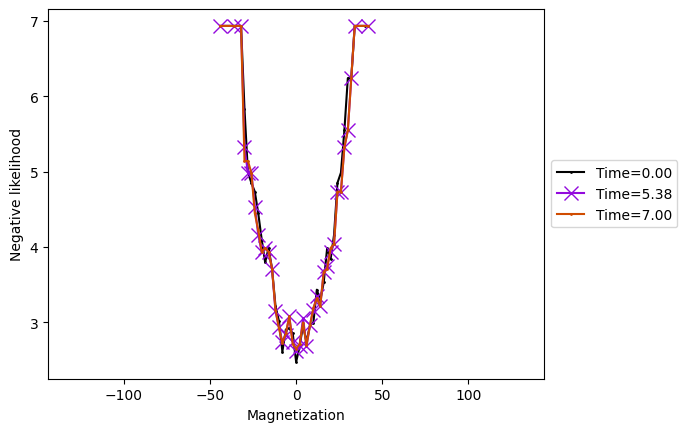

In [5]:
# line_color = [plt.colormaps["jet_r"](float(i)/float(len(diffusion_t))) for i in range(len(diffusion_t))]
line_color = [plt.colormaps["gnuplot"](float(i)/3.) for i in range(3)]
line_marker = ["o", "x", "o"]
line_s = [1, 10, 1]
# for i in range(0, len(diffusion_t), 10):
for idx_t, i in enumerate([0, len(diffusion_t)-10, len(diffusion_t)-1]):
    # if diffusion_t[i] >= 1.0:
    #     break
    hist_E, bin_centers_E, P_E, F_E, idxF_E = histvar(seq_t[i], Ising_magnetization, bins)
    plt.plot(bin_centers_E[idxF_E], F_E, label="Time=%.2f"%(diffusion_t[i]), c=line_color[idx_t], marker=line_marker[idx_t], markersize=line_s[idx_t])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("Magnetization")
plt.ylabel("Negative likelihood")
plt.xlim((magn.min(), magn.max()))

In [ ]:
36*36